# Imports

In [1]:
! pip install ultralytics
! pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 7.2 MB/s eta 0:00:00


In [2]:
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
root_dir="/kaggle/input/indoor-object-detection"
train_imgs_dir="/kaggle/input/indoor-object-detection/train/images"
valid_imgs_dir="/kaggle/input/indoor-object-detection/test/images"
test_imgs_dir="/kaggle/input/indoor-object-detection/test/images"

In [4]:
train_labels_dir="/kaggle/input/indoor-object-detection/train/labels"
valid_labels_dir="/kaggle/input/indoor-object-detection/test/labels"
test_labels_dir="/kaggle/input/indoor-object-detection/test/labels"

# Visualization

In [5]:
names={0:"door",1:"cabinetDoor",2:"refrigeratorDoor",3:"window",4:"chair",5:"table",
       6:"cabinet",7:"couch",8:"openedDoor",9:"pole"}
COLORS=np.random.uniform(0,255,(10,3))

In [6]:
def show_bbox(img_name,img_dir,label_dir,axis):
    img_path=os.path.join(img_dir,img_name)
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,_=img.shape
    img=img.copy()
    
    try:
        label_path=os.path.join(label_dir,img_name[:-4]+".txt")
        label=pd.read_csv(label_path,sep=" ",header=None).values
        classes=label[:,0]
        boxes=label[:,1:]
        
        for i,box in enumerate(boxes):
            cls_id=int(classes[i])
            text=names[cls_id]
            color=COLORS[cls_id]
            xmin=int((box[0]-box[2]/2)*w)
            ymin=int((box[1]-box[3]/2)*h)
            xmax=int((box[0]+box[2]/2)*w)
            ymax=int((box[1]+box[3]/2)*h)
            cv2.rectangle(img,(xmin,ymin),(xmax,ymax),color,3)
            y=ymin-10 if ymin-10>10 else ymin+20
            cv2.putText(img,text,(xmin,y),cv2.FONT_HERSHEY_SIMPLEX,1.5,color,3)
    except:
        pass
    
    axis.imshow(img)
    axis.axis("off")

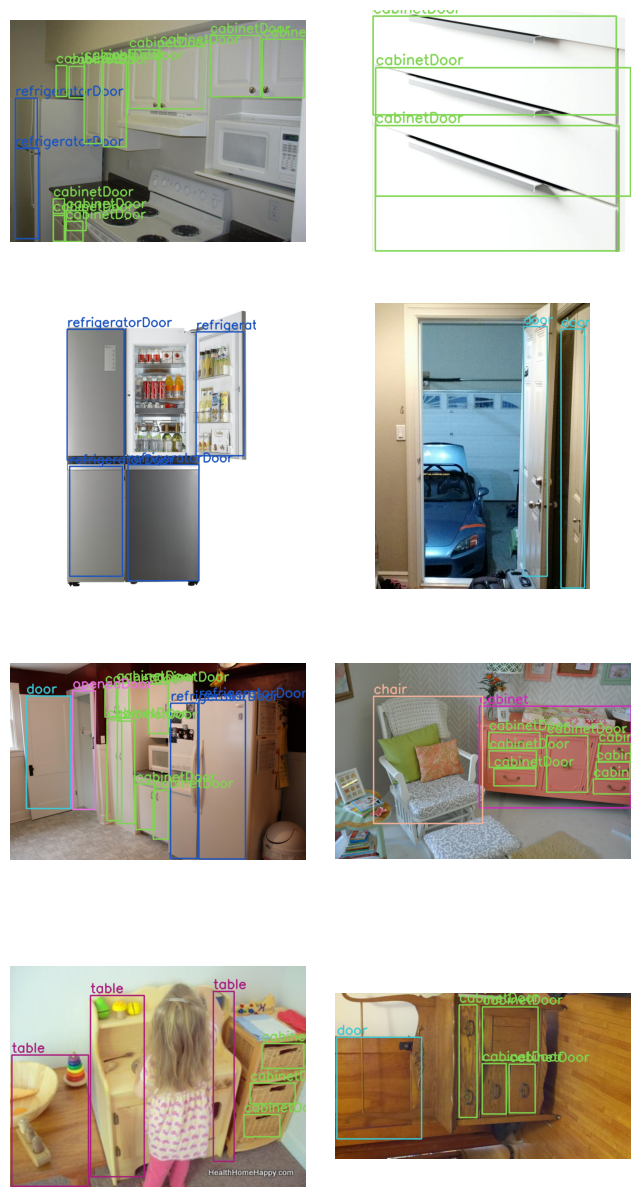

In [7]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()


train_img_list=sorted(os.listdir(train_imgs_dir))
img_name_list=np.random.choice(train_img_list,8)


for i,img_name in enumerate(img_name_list):
    show_bbox(img_name,train_imgs_dir,train_labels_dir,ax[i])
    
plt.savefig("1.png")

# Yolo Format

The Ultralytics YOLO format is a dataset configuration format that allows you to define the dataset root directory, the relative paths to training/validation/testing image directories or *.txt files containing image paths, and a dictionary of class names.

In [8]:
yolo_format=dict(path=root_dir,
                 train=train_imgs_dir,
                 val=valid_imgs_dir,
                 nc=10,
                 names=names)
             
with open('/kaggle/working/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

# Wandb login

This is a required step for training, you can look at small tutorial for help
**[Weights & Biases Tutorial](https://www.kaggle.com/code/samuelcortinhas/weights-biases-tutorial-beginner)**

In [9]:
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Wandb")

wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Training

In [10]:
"""Device is determined automatically. If a GPU is available then it will be used, 
   otherwise training will start on CPU."""

model=YOLO('yolov8l.pt')
model.train(data="/kaggle/working/yolo.yaml",epochs=150,patience=20,batch=8,
            lr0=0.0003,imgsz=640,freeze=6)

100%|██████████| 83.7M/83.7M [00:00<00:00, 243MB/s]
Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/kaggle/working/yolo.yaml, epochs=150, patience=20, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=6, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78e456ac8c10>
fitness: 0.24513181846142795
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.21487,     0.19597,     0.69626,     0.39224,     0.17474,    0.075033,     0.20594,     0.13402,     0.14921,    0.036358])
names: {0: 'door', 1: 'cabinetDoor', 2: 'refrigeratorDoor', 3: 'window', 4: 'chair', 5: 'table', 6: 'cabinet', 7: 'couch', 8: 'openedDoor', 9: 'pole'}
plot: False
results_dict: {'metrics/precision(B)': 0.4647833549141751, 'metrics/recall(B)': 0.41328601879965066, 'metrics/mAP50(B)': 0.4041432804724952, 'metrics/mAP50-95(B)': 0.227463878237976, 'fitness': 0.24513181846142795}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 0.1283271290431513, 'inference': 13.8598513

# Validate

In [11]:
path_best_weights="/kaggle/working/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val(conf=0.20,iou=0.70) 

Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 268 layers, 43614318 parameters, 0 gradients
val: Scanning /kaggle/input/indoor-object-detection/test/labels... 104 images, 3 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<00:00, 275.91it/s]
val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]
                   all        107        550      0.449       0.43      0.449      0.268
                  door        107         34      0.498       0.38      0.478      0.287
           cabinetDoor        107        179       0.53      0.579      0.551      0.239
      refrigeratorDoor        107          2      0.667          1      0.995      0.713
                window        107         63      0.634      0.577      0.654   

In [12]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.26773021519208934
Mean Average Precision @ .50   : 0.4486317146196009
Mean Average Precision @ .70   : 0.30583463671145605


In [13]:
columns=["Mean_Avg_Precision"]
cls_map=pd.DataFrame(metrics.box.maps,columns=columns,index=names.values())
cls_map.style.background_gradient(subset=columns,cmap="YlOrRd",high=0.75)

,Mean_Avg_Precision
door,0.286940
cabinetDoor,0.238725
refrigeratorDoor,0.713000
window,0.444458
chair,0.223847
table,0.105898
cabinet,0.265352
couch,0.167085
openedDoor,0.179192
pole,0.052804


# Prediction

In [14]:
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.20,iou=0.70)


image 1/107 /kaggle/input/indoor-object-detection/test/images/1003.png: 480x640 2 doors, 1 table, 1 cabinet, 68.3ms
image 2/107 /kaggle/input/indoor-object-detection/test/images/1014.png: 480x640 1 window, 18.2ms
image 3/107 /kaggle/input/indoor-object-detection/test/images/1015.png: 480x640 2 cabinetDoors, 1 openedDoor, 18.2ms
image 4/107 /kaggle/input/indoor-object-detection/test/images/1020.png: 480x640 1 openedDoor, 18.2ms
image 5/107 /kaggle/input/indoor-object-detection/test/images/1021.png: 480x640 1 window, 18.2ms
image 6/107 /kaggle/input/indoor-object-detection/test/images/1023.png: 480x640 1 door, 1 window, 1 chair, 1 table, 1 openedDoor, 18.2ms
image 7/107 /kaggle/input/indoor-object-detection/test/images/1026.png: 480x640 2 doors, 1 window, 3 couchs, 18.2ms
image 8/107 /kaggle/input/indoor-object-detection/test/images/1027.png: 480x640 1 chair, 1 table, 1 cabinet, 3 couchs, 18.2ms
image 9/107 /kaggle/input/indoor-object-detection/test/images/1028.png: 480x640 1 door, 3 ch

In [15]:
# directory for saving predictions on test dataset
!mkdir "/kaggle/working/prediction_yolo8vl"

In [16]:
prediction_dir="/kaggle/working/prediction_yolo8vl"

In [17]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xywhn.cpu().numpy()
        classes=result.boxes.cls.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for cls_obj,box in zip(classes,boxes):
                text=f"{int(cls_obj)} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

# Prediction Visualization

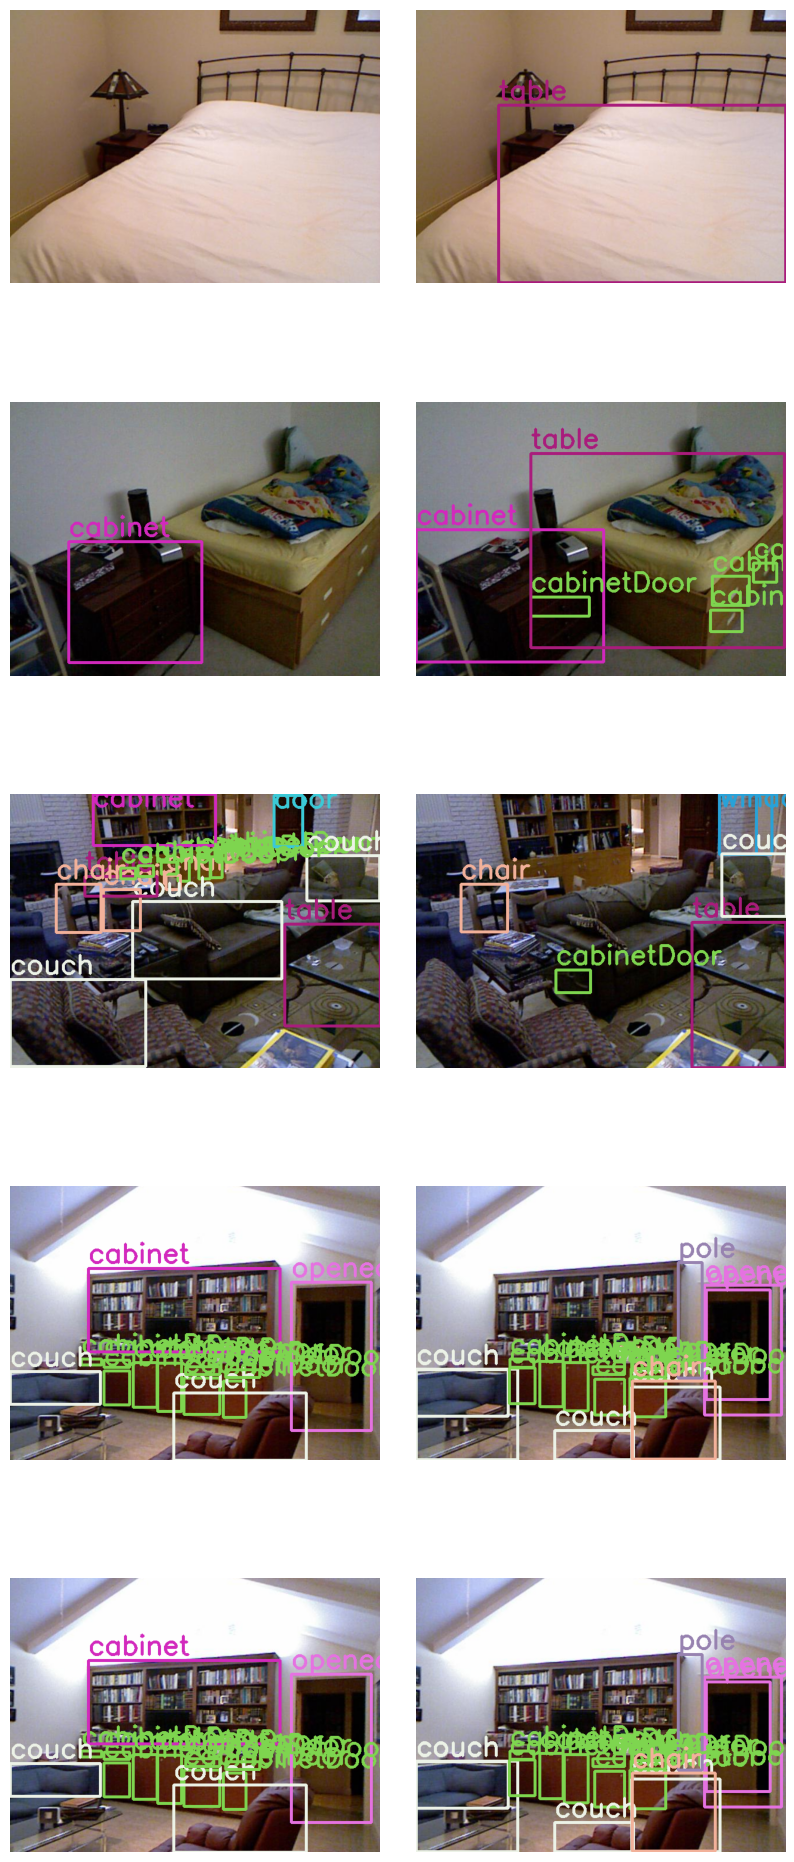

In [18]:
fig,axes=plt.subplots(5,2,figsize=(10,25))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

test_img_list=list(sorted(os.listdir(test_imgs_dir)))
imgs_name=np.random.choice(test_img_list,5)

for i,img_name in enumerate(imgs_name):
    #ground truth
    show_bbox(img_name,test_imgs_dir,test_labels_dir,axis=axes[i,0])
    
    #predicted label
    show_bbox(img_name,test_imgs_dir,prediction_dir,axis=axes[i,1])
    
plt.savefig("2.png")